In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower
import pandas as pd
import re

In [2]:
omega_nu = np.array([0.0006356, 0.002, 0.006356])
omega_index = 0 # while we debug, we confine our attention to just one value

In [3]:
# Keep in mind that this is NOT the same file as the original "cosmology_Aletheia.dat"
# that Ariel gave us! If you use the unaltered version, you will get a segfault
cosm = pd.read_csv("cosmologies.dat", sep='\s+')

# The following code is somewhat hard;
# I'm not sure how better to do it.
redshift_column = re.compile("z.+")

def parse_redshifts(model_num):
    z = []
    model = cosm.loc[model_num]
    
    for column in cosm.columns:
        if redshift_column.match(column):
            z.append(model[column])
    return np.array(z)

In [4]:
def kzps(mlc, omnuh2_in, massive_neutrinos=False, sigma12_in=1, zs = [0]):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model
    @param mlc : "MassLess Cosmology"
        a dictionary of values
        for CAMBparams fields
    @param omnuh2_in : neutrino physical mass density
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the desired sigma12 of the model
    @massive_neutrinos : if this is True,
        the value in omnuh2_in is used to set omnuh2.
        If this is False,
        the value in omnuh2_in is simply added to omch2.
    """
    pars = camb.CAMBparams()
    omch2_in = mlc["omch2"]
    if massive_neutrinos:
        omch2_in = mlc["omch2"] - omnuh2_in
        pars.omnuh2=omnuh2_in
    pars.set_cosmology(
        H0=mlc["h"] * 100,
        ombh2=mlc["ombh2"],
        omch2=omch2_in,
        omk=mlc["OmK"])
    pars.InitPower.set_params(As=mlc["A_s"], ns=mlc["n_s"])
    pars.set_dark_energy(w=mlc["w0"], wa=float(mlc["wa"]))
    
    pars.set_matter_power(redshifts=zs, kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    
    if sigma12_in != 1:
        sigma12_unmodified = results.get_sigmaR(12, hubble_units=False)
        As_rescaled = 2e-9 * (sigma12_in / sigma12_unmodified) ** 2

        pars.InitPower.set_params(As=As_rescaled, ns=mlc["n_s"])

    k, z, p = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    return k, z, p, sigma12

In [5]:
# Let us begin our demonstration by considering only the
# middle of the
# given neutrino mass physical densities, omega_nu[omega_index]
k_massless_list = []
z_massless_list = []
p_massless_list = []
s12_massless_list = []

k_massive_list = []
z_massive_list = []
p_massive_list = []
s12_massive_list = []

for index, row in cosm.iterrows():
    # Basically hard-code ignoring pattern
    # Until we figure out the DE shenanigans
    if row["wa"] == "-" or row["w0"] + float(row["wa"]) < -1:
        continue # not sure how to handle this yet
    if index > 2:
        continue # we're confining our attention while we debug

    z_in = parse_redshifts(index)
    
    k, z, p, s12 = kzps(row, omega_nu[omega_index], massive_neutrinos=False,
                       zs=z_in)
    k_massless_list.append(k)
    z_massless_list.append(z)
    p_massless_list.append(p)
    s12_massless_list.append(s12)
    
    k, z, p, s12 = kzps(row, omega_nu[omega_index], massive_neutrinos=True,
                       zs=z_in)
    k_massive_list.append(k)
    z_massive_list.append(z)
    p_massive_list.append(p)
    s12_massive_list.append(s12)

In [6]:
colors = ["green", "blue", "brown"]

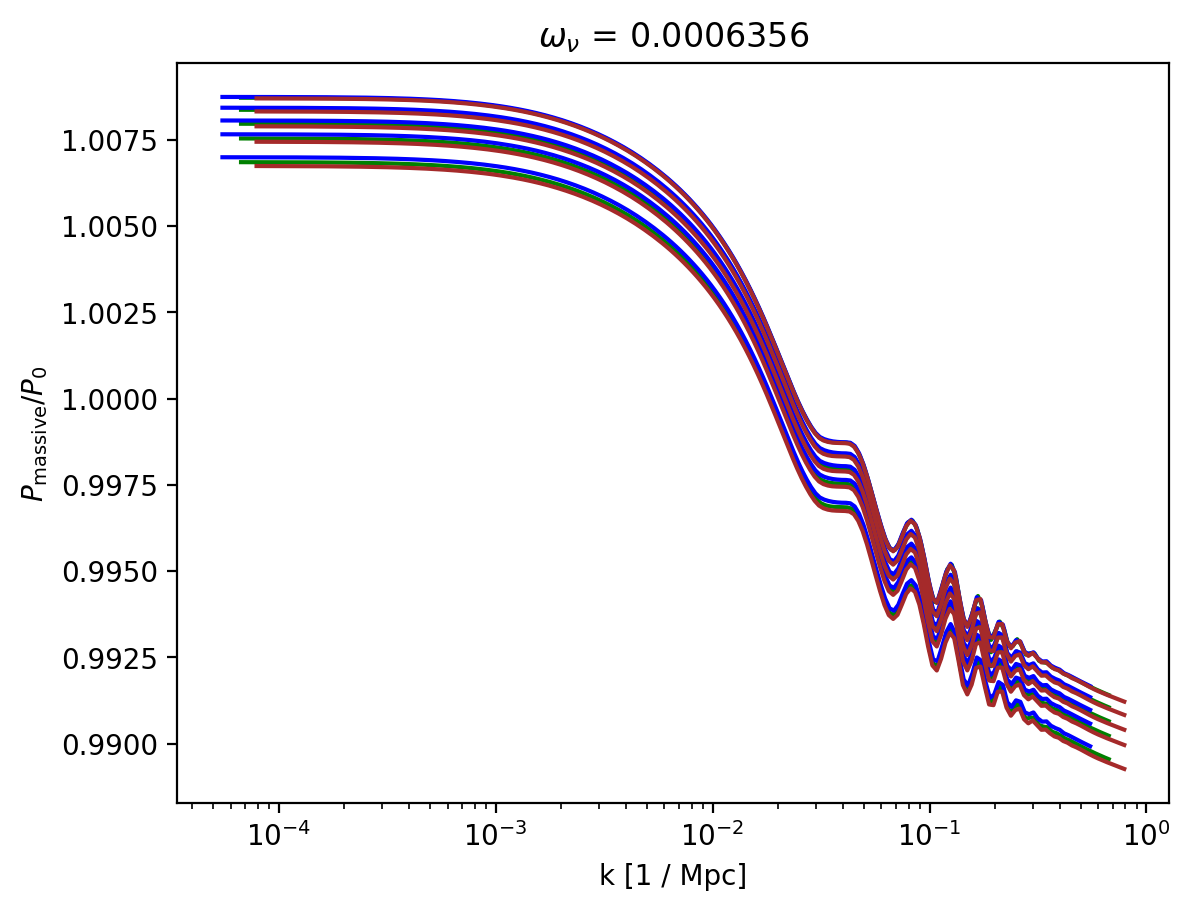

In [7]:
for i in range(0, 3):
    h = cosm.loc[i]["h"]
    for j in range(5):
        plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i) + \
                 ", no renormalizing, z=" + str(parse_redshifts(index)[j]),
                c=colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]))
    #plt.legend()

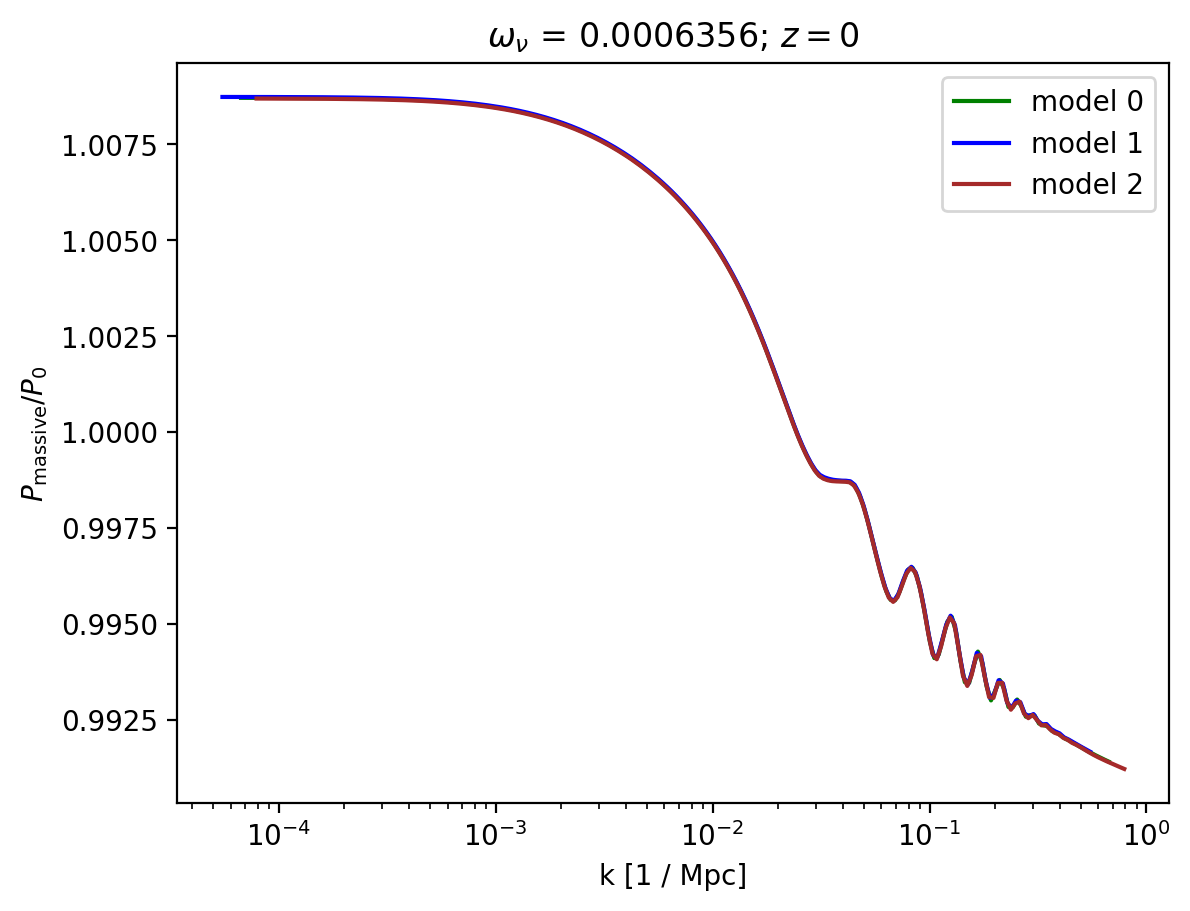

In [8]:
for i in range(0, 3):
    h = cosm.loc[i]["h"]
    j = 4 # just look at z=0 before moving on
    plt.plot(k_massless_list[i] * h, p_massive_list[i][j] / p_massless_list[i][j],
                 label="model " + str(i), c=colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(omega_nu[omega_index]) + "; $z=0$")
    plt.legend()

Problems? and problems:
* I am currently not re-normalizing the amplitude of one model mased on its counterpart. At least, I *think* I'm not doing that.
* I need to set a k_min value so that the x axes align better